 <a href="https://colab.research.google.com/github/labudzki/ComputationalBiology/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sp
import numpy as np

Question 1: Experimental data from an enzyme kinetics experiment is provided in Kinetics.csv file.
The file contains two substrate (S1 and S2) concentrations (in mM) and corresponding rates (in mM/s). (5 points)
1. Identify the underlying enzyme kinetics mechanism
Hint: Use Chi-squared/R-squared measures
2. Make (a) Eadie-Hofstee and (b) Lineweaver-Burk plots for different S2 values of 1.5, 2.5 and 5 mM
3. Extract Michaelis constants (Km1, Km2) and Vmax from the Eadie-Hofstee plot

In [59]:
def import_kinetics_data(file_path, s2_threshold=1.0):
    """
    Reads the kinetics CSV file and returns filtered dataframe.
    """
    try:
        data = pd.read_csv(file_path)
        return data[data['S2'] <= s2_threshold]
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

In [60]:
# Defining functions to determine underlying enzyme kinetics
def linear(x, a, b):
    return a * x + b

def sqrt_func(x, a, b):
    return a * np.sqrt(x) + b

def type_1a(S1, S2, K1, K2, v_max):
    return (v_max * S1 * S2) / (K2 * K1 + K2 * S1 + S1 * S2)

def type_1b(S1, S2, K1, K2, v_max):
    return (v_max * S1 * S2) / (K1 * K2 + K2 * S1 + K1 * S2 + S1 * S2)

def type_2(S1, S2, K1, K2, v_max):
    return (v_max * S1 * S2) / (K2 * S1 + K1 * S2 + S1 * S2)

In [61]:
# Defining functions to plot linear and square root fit
def plot_linear_fit(s1_data, s2_data, rate_data):
    """
    Plots the linear fit of the kinetics data
    """
    params_linear, _ = sp.curve_fit(linear, s1_data, rate_data)
    x_fit = np.linspace(0, 1, 10)
    plt.figure()
    plt.scatter(s1_data, rate_data, label='S1')
    plt.scatter(s2_data, rate_data, label='S2')
    plt.plot(x_fit, linear(x_fit, *params_linear), color='red', label='Linear Fit')
    plt.legend()
    plt.xlabel('substrate [units]')
    plt.ylabel('rate [units]')
    plt.title('Linear fit')
    plt.show()

def plot_sqrt_fit(s1_data, s2_data, rate_data):
    """
    Plots the square root fit of the kinetics data
    """
    params_sqrt, _ = sp.curve_fit(sqrt_func, s1_data, rate_data)
    x_fit = np.linspace(0, 1, 100)
    plt.figure()
    plt.scatter(s1_data, rate_data, label='S1')
    plt.scatter(s2_data, rate_data, label='S2')
    plt.plot(x_fit, sqrt_func(x_fit, *params_sqrt), color='red', label='Sqrt Fit')
    plt.legend()
    plt.xlabel('substrate [units]')
    plt.ylabel('rate [units]')
    plt.title('Sqrt fit')
    plt.show()


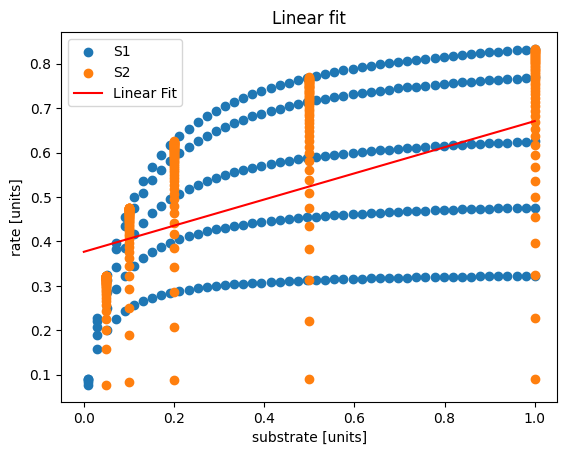

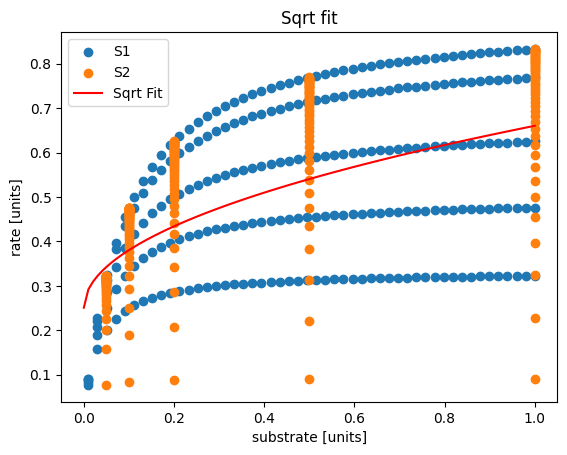

In [62]:
# Import data and define substrate and rate data
data = import_kinetics_data("Kinetics.csv")
s1_data = data.iloc[:, 0]
rate_data = data.iloc[:, 1]
s2_data = data.iloc[:, 2]

# Plot linear and square root fit
plot_linear_fit(s1_data, s2_data, rate_data)
plot_sqrt_fit(s1_data, s2_data, rate_data)


In [63]:
# Defining goodness of fit measures
def r_squared(y, y_fit):
    """
    Calculates the R-squared value, which measures how well the model fits the data.
    """
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - (ss_res / ss_tot)

def chi_squared(y, y_fit):
    """
    Calculates the Chi-squared value, which measures the difference between observed
    and fitted data.
    """
    return np.sum(((y - y_fit) ** 2) / y_fit)

In [64]:
def prepare_kinetics_input(data):
    """
    Prepares the CSV data to be used in our model.
    """
    s1 = data.iloc[:, 0].to_numpy()
    rate = data.iloc[:, 1].to_numpy()
    s2 = data.iloc[:, 2].to_numpy()
    x_input = np.column_stack((s1, s2))
    return s1, s2, rate, x_input

def fit_model(model_type, s1, s2, rate, x_input):
    """
    Fits data to specified model types using the SciPy curve fit function.
    """
    params, _ = sp.curve_fit(
        lambda xy, K1, K2, v_max: model_type(s1, s2, K1, K2, v_max),
        x_input,
        rate
    )
    return params

def evaluate_fit(model_type, s1, s2, rate, params):
    """
    Calculates goodness of fit measures for specified model type.
    """
    fitted_data = model_type(s1, s2, *params)
    r2 = r_squared(rate, fitted_data)
    chi2 = chi_squared(rate, fitted_data)
    return r2, chi2

def run_all_models(data, models):
    """
    Calculates and prints optimal parameters and goodness of fit measures
    for all models.
    """
    s1, s2, rate, x_input = prepare_kinetics_input(data)

    for label, model_type in models.items():
        params = fit_model(model_type, s1, s2, rate, x_input)
        r2, chi2 = evaluate_fit(model_type, s1, s2, rate, params)
        print(f"{label}:")
        print(f"Params: {params}")
        print(f"R²: {r2:.4f}")
        print(f"χ²: {chi2:.4f}\n")


In [65]:
models = {
    "Type 1a": type_1a,
    # "Type 1b": type_1b, # Type 1b commented out due to diverging results
    "Type 2": type_2
}

run_all_models(data, models)

Type 1a:
Params: [0.58274069 0.03829853 0.82071202]
R²: 0.9169
χ²: 2.8937

Type 2:
Params: [0.1 0.1 1. ]
R²: 1.0000
χ²: 0.0000



Type 1a: R-squared: 0.9169
Chi-squared: 2.8937

Type 1b: Diverged

Type 2: R-squared: 1.0000
Chi-squared: 0.0000

The fit for Type 2 is a perfect fit. This is type 2 enzyme kinetics.


Make (a) Eadie-Hofstee and (b) Lineweaver-Burk plots for different S2 values of 1.5, 2.5 and
5 mM

In [87]:
def plot_eadie_hofstee(data):
    """
    Outputs an Eadie-Hofstee plot for the given data.
    """
    plt.figure(figsize=(5, 5))
    K1_vals = []
    vmax_vals = []

    for s2, s1, v in data:
        v_over_s1 = v / s1
        plt.scatter(v_over_s1, v, label=f"S2 = {s2} mM")

        # Linear regression
        slope, intercept = np.polyfit(v_over_s1, v, 1)
        K1, vmax = -slope, intercept

        K1_vals.append(K1)
        vmax_vals.append(vmax)

        x_fit = np.linspace(min(v_over_s1), max(v_over_s1), 100)
        y_fit = slope * x_fit + intercept
        plt.plot(x_fit, y_fit, linestyle='--', alpha=0.6)

    plt.xlabel("v / [S1] (mM⁻¹ s⁻¹)")
    plt.ylabel("v (mM/s)")
    plt.title("Eadie-Hofstee Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

    return K1_vals, vmax_vals

def plot_lineweaver_burk(data):
    """
    Outputs a Lineweaver-Burk plot for the given data
    """

    plt.figure(figsize=(5, 5))

    for s2, s1, v in data:
        inv_s1 = 1 / s1
        inv_v = 1 / v
        plt.scatter(inv_s1, inv_v, label=f"S2 = {s2} mM")

        slope, intercept = np.polyfit(inv_s1, inv_v, 1)
        x_fit = np.linspace(min(inv_s1), max(inv_s1), 100)
        y_fit = slope * x_fit + intercept
        plt.plot(x_fit, y_fit, linestyle='--', alpha=0.6)

    plt.xlabel("1 / [S1] (mM⁻¹)")
    plt.ylabel("1 / v (s/mM)")
    plt.title("Lineweaver-Burk Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_km2(K1_vals, vmax_vals, data):
    """
    Computes Km2 using the Type 2 velocity equation and known K1, Vmax values.
    """
    for idx, (s2, s1_array, v_array) in enumerate(data):
        s1 = s1_array[idx]
        v = v_array[idx]
        vmax = vmax_vals[idx]
        K1 = K1_vals[idx]

        # Derived from type 2 model: v = (vmax * s1 * s2) / (K1 * s2 + K2 * s1 + s1 * s2)
        K2 = (vmax * s1 * s2 - v * K1 * s2 - v * s1 * s2) / (v * s1)
        print(f"S2 = {s2:.2f}, Km1 = {K1:.4f}, Km2 = {K2:.4f}, Vmax = {vmax:.4f}")

def analyze_kinetics_with_data(data, s2_targets):
    """
    Groups S1, S2, and Rate data by selected S2 values and performs full kinetic analysis.
    """
    s1_all = data['S1'].to_numpy()
    rate_all = data['Rate'].to_numpy()
    s2_all = data['S2'].to_numpy()

    grouped_data = []

    for s2_val in s2_targets:
        mask = s2_all == s2_val
        s1_subset = s1_all[mask]
        rate_subset = rate_all[mask]
        grouped_data.append((s2_val, s1_subset, rate_subset))

    K1_vals, vmax_vals = plot_eadie_hofstee(grouped_data)
    compute_km2(K1_vals, vmax_vals, grouped_data)
    plot_lineweaver_burk(grouped_data)

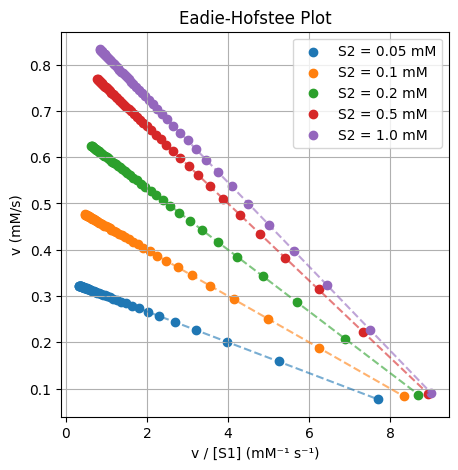

S2 = 0.05, Km1 = 0.0333, Km2 = 0.0000, Vmax = 0.3333
S2 = 0.10, Km1 = 0.0500, Km2 = -0.0000, Vmax = 0.5000
S2 = 0.20, Km1 = 0.0667, Km2 = 0.0000, Vmax = 0.6667
S2 = 0.50, Km1 = 0.0833, Km2 = -0.0000, Vmax = 0.8333
S2 = 1.00, Km1 = 0.0909, Km2 = -0.0000, Vmax = 0.9091


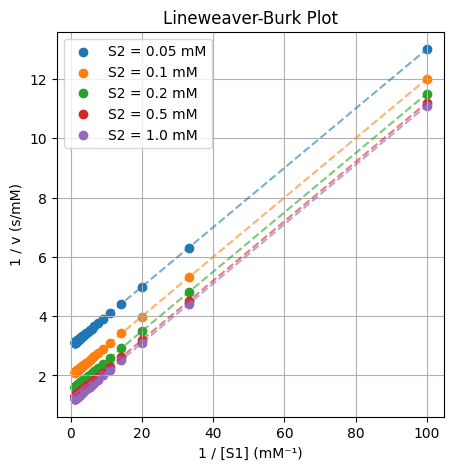

In [88]:
# Plots Eadie-Hofstee and Lineweaver-Burk plots with Km1, Km2, and Vmax parameters.
s2_targets = [.05, 0.1, 0.2, 0.5, 1.0]
analyze_kinetics_with_data(data, s2_targets)